In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.datasets import load_breast_cancer
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = load_breast_cancer()
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df['target'] = data.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

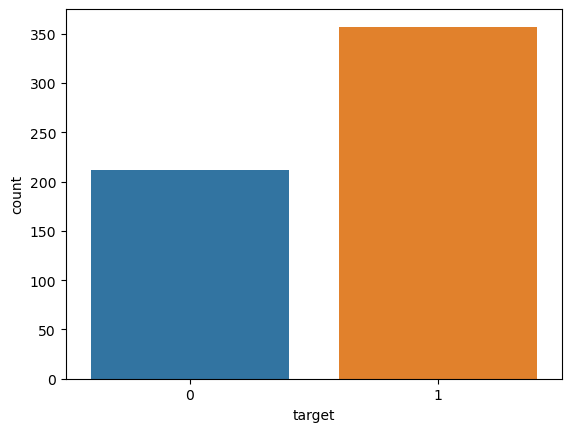

In [8]:
sns.countplot(x = df.target)
plt.show()

* Видим явный дисбаланс классов, также в датасете всего 589 наблюдений, поэтому хорошим решением будет использование стратификированного к фолд кросс валидацию.

In [9]:
skf = StratifiedKFold(n_splits=6, shuffle = True, random_state = 1)

In [10]:
X = df.drop(['target'], axis=1)
y = df['target']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.35, 
                                                    random_state = 1, 
                                                    shuffle=True, 
                                                    stratify=y)

* тест сайз поставим 0.35, так как у нас мало данных и хочется получить более объективные метрики.

In [12]:
scaler = MinMaxScaler()
pca = PCA()
logreg = LogisticRegression(max_iter=1000, tol=0.001)
knc = KNeighborsClassifier()
rfc = RandomForestClassifier(max_features='sqrt')
booster = CatBoostClassifier(loss_function='Logloss', verbose=False)


pipe_logreg = Pipeline(steps=[('scaler', scaler), 
                              ('pca', pca), 
                              ('logreg', logreg)])

pipe_rfc = Pipeline(steps=[('scaler', scaler), 
                           ('rfc', rfc)])

pipe_knc = Pipeline(steps=[('scaler', scaler),
                           ('knc', knc)])

pipe_booster = Pipeline(steps=[('scaler', scaler), 
                               ('booster', booster)])

* обучим случайный лес, кнн, логистическую регрессию и катбуст(градиентный бустинг над деревьями). Для логистической регрессии, так как довольно много признаков(30), используем pca - численный метод понижения размерности, для остальных моделей pca в целом применять не нужно, так как они не являюстя линейныйми.

In [15]:
param_grid_logreg = {
    'pca__n_components': [int(x) for x in range(1,31)],
    'logreg__C': np.logspace(-4, 4, 4),
    'logreg__solver': ['lbfgs', 'liblinear']
}

search_logreg = GridSearchCV(pipe_logreg, param_grid_logreg, n_jobs=-1, cv = skf, verbose=1)
search_logreg.fit(X_train, y_train)
print('Best parameter (CV score_train_logreg=%0.3f):' % search_logreg.best_score_)
print(search_logreg.best_params_)

Fitting 6 folds for each of 240 candidates, totalling 1440 fits
Best parameter (CV score_train_logreg=0.984):
{'logreg__C': 21.54434690031882, 'logreg__solver': 'lbfgs', 'pca__n_components': 11}


In [16]:
param_grid_knc = {
    'knc__n_neighbors':[int(x) for x in range(2, 30)],
    'knc__weights': ['uniform', 'distance'],
    'knc__algorithm':['ball_tree', 'kd_tree', 'brute']
}
search_knc = GridSearchCV(pipe_knc, param_grid_knc, n_jobs=-1, cv = skf, verbose=1)
search_knc.fit(X_train, y_train)
print('Best parameter (CV score_train_knc=%0.3f):' % search_knc.best_score_)
print(search_knc.best_params_)

Fitting 6 folds for each of 168 candidates, totalling 1008 fits
Best parameter (CV score_train_knc=0.976):
{'knc__algorithm': 'ball_tree', 'knc__n_neighbors': 3, 'knc__weights': 'uniform'}


In [17]:
param_grid_rfc = {
    'rfc__n_estimators': [int(x) for x in range(100, 551, 50)],
    'rfc__max_depth': [int(x) for x in range(3, 13, 2)]
}
search_rfc = GridSearchCV(pipe_rfc, param_grid_rfc, n_jobs=-1, cv = skf, verbose=1)
search_rfc.fit(X_train, y_train)
print('Best parameter (CV score_train_rfc=%0.3f):' % search_rfc.best_score_)
print(search_rfc.best_params_)

Fitting 6 folds for each of 50 candidates, totalling 300 fits
Best parameter (CV score_train_rfc=0.965):
{'rfc__max_depth': 9, 'rfc__n_estimators': 300}


In [13]:
param_grid_booster = {
    'booster__iterations':[int(x) for x in range(50, 401, 50)],
    'booster__learning_rate': [x / 100.0 for x in range(5,50,10)],
    'booster__depth':[int(x) for x in range(6,11,2)]
}
search_booster = GridSearchCV(pipe_booster, param_grid_booster, n_jobs=-1, cv = skf)
search_booster.fit(X_train, y_train)
print('Best parameter (CV score_train_booster=%0.3f):' % search_booster.best_score_)
print(search_booster.best_params_)

Best parameter (CV score_train_booster=0.970):
{'booster__depth': 8, 'booster__iterations': 50, 'booster__learning_rate': 0.05}


* Модели обучены на трейне, параметры подобраны, можем теперь посмотреть на результаты на тесте.

In [18]:
y_pred_logreg = search_logreg.best_estimator_.predict(X_test)
y_pred_knc = search_knc.best_estimator_.predict(X_test)
y_pred_rfc = search_rfc.best_estimator_.predict(X_test)
y_pred_booster = search_booster.best_estimator_.predict(X_test)

In [19]:
pred_models = [y_pred_logreg, y_pred_knc, y_pred_rfc, y_pred_booster]
pred_models_title = ['logreg', 'knc', 'rfc', 'booster']

In [20]:
def conf_matr(pred_models, pred_models_title):
    cm = confusion_matrix(y_test, pred_models[i])
    cmd = ConfusionMatrixDisplay(cm, display_labels=[1,0])
    cmd.plot()
    plt.title(f'confusion_matrix of {pred_models_title[i]}', fontsize = 13)
    plt.show()

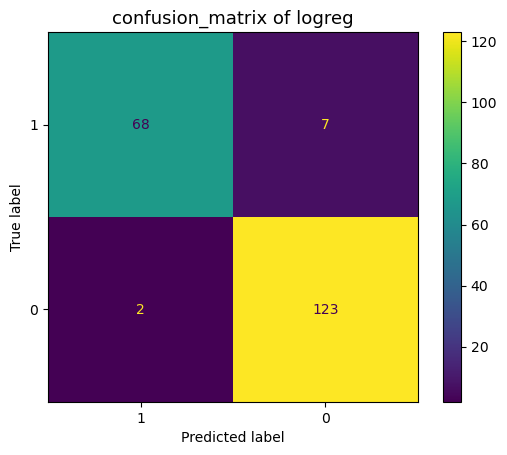

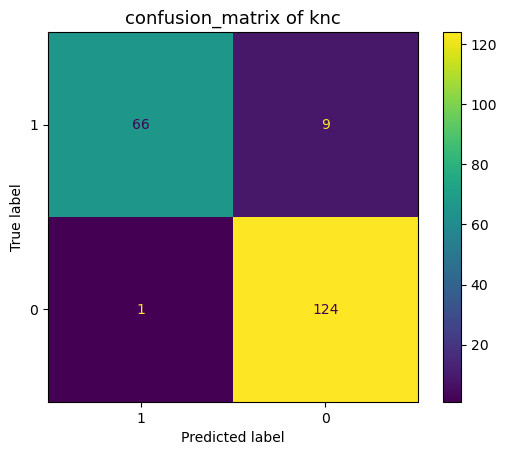

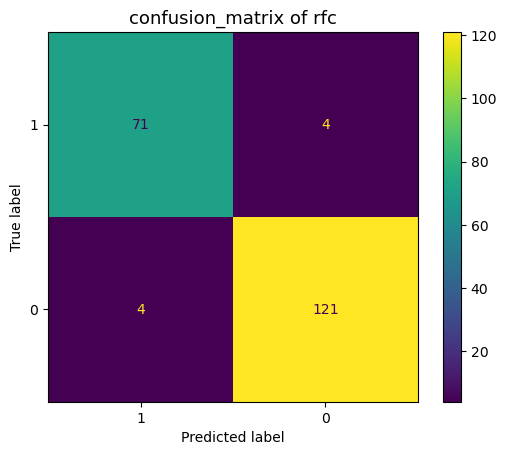

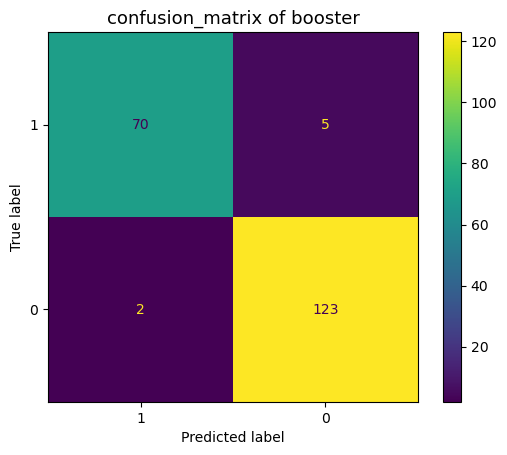

In [21]:
for i in range(4):
    conf_matr(pred_models, pred_models_title)

In [22]:
def roc_cur(pred_models, pred_models_title):    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_models[i])
    plt.figure(figsize=(6, 6))

    plt.title(f'roc-curve of {pred_models_title[i]}', fontsize = 13)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    

    plt.plot(fpr, tpr, color='palevioletred')
    plt.plot([0, 1], [0, 1], linestyle='--', color='green')

    plt.grid()
    plt.show()

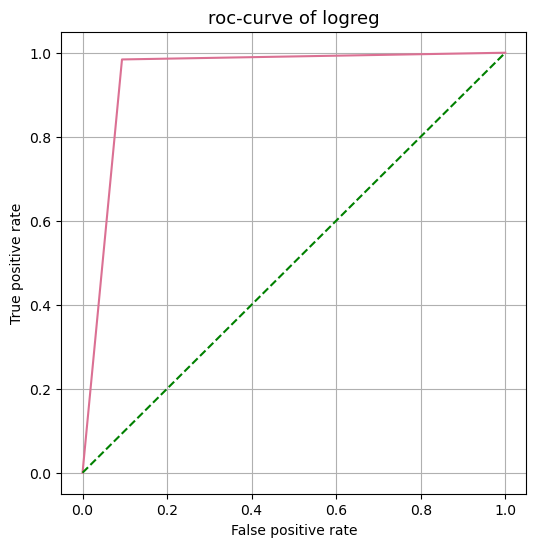

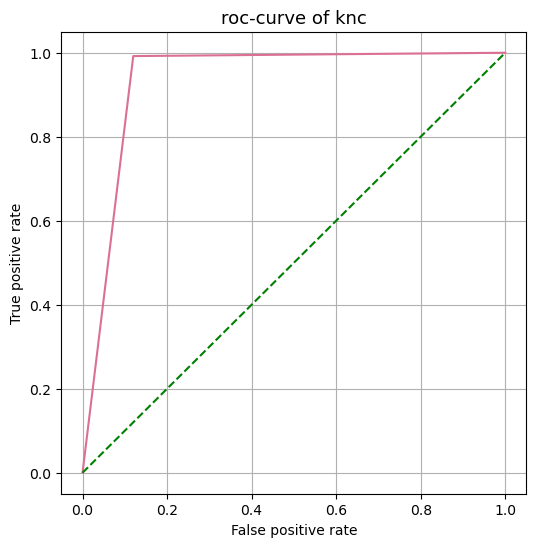

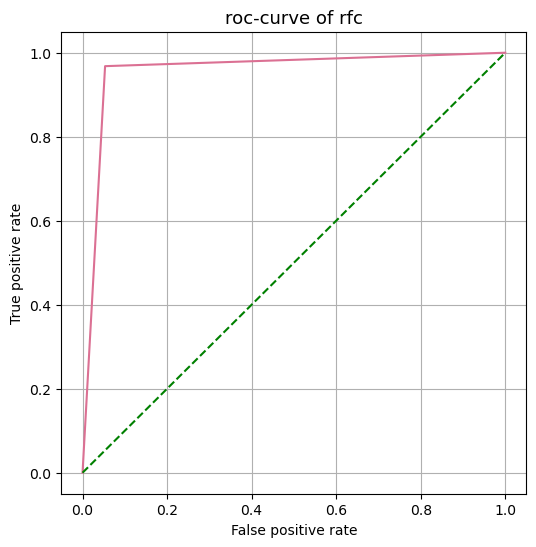

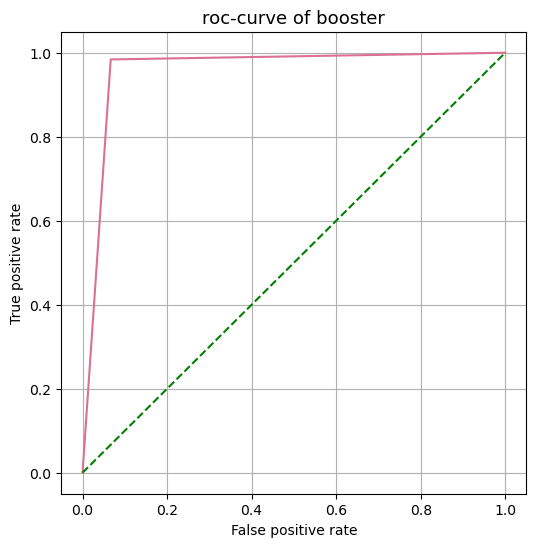

In [23]:
for i in range(4):
    roc_cur(pred_models, pred_models_title)

In [24]:
precisions = []
recalls = []
f1s = []
accuracies = []
roc_aucs = []

def metricss(pred_models):
    precisions.append(metrics.precision_score(y_test, pred_models[i]))
    recalls.append(metrics.recall_score(y_test, pred_models[i]))
    f1s.append(metrics.f1_score(y_test, pred_models[i]))
    accuracies.append(metrics.accuracy_score(y_test, pred_models[i]))
    roc_aucs.append(metrics.roc_auc_score(y_test, pred_models[i]))

In [25]:
for i in range(4):
    metricss(pred_models)

In [26]:
Metrics = pd.DataFrame(
    {'precisions': precisions,
     'recalls': recalls,
     'f1s': f1s,
     'accuracies': accuracies,
     'roc_aucs': roc_aucs,
    })
Metrics.rename(index={0: "logreg", 1: "knc", 2: "rfc", 3: 'booster'}, inplace=True)
Metrics

,precisions,recalls,f1s,accuracies,roc_aucs
logreg,0.946154,0.984,0.964706,0.955,0.945333
knc,0.932331,0.992,0.961240,0.950,0.936000
rfc,0.968000,0.968,0.968000,0.960,0.957333
booster,0.960938,0.984,0.972332,0.965,0.958667


* мы рассмотрим долю правильно найденных положительных объектов среди всех объектов положительного класса (recall), будем ориентироваться на эту метрику так как нам важно в нашей задаче, чтобы пропущенных опухолей было как можно меньше, таким образом, как ни странно, стоит выбрать классификатор к соседей.